In [0]:
#######################################################################
######### Creating the star rating model using yelp data ##############
#######################################################################

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import tweepy
import os
from pathlib import Path
import json
import re
import random

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [0]:
link = 'https://drive.google.com/open?id=1jbaNXrRoD6IjmzXwPYuTv8LokxzGwjHb'


In [81]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1jbaNXrRoD6IjmzXwPYuTv8LokxzGwjHb


In [82]:
# Loading the data
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Confirmed.csv') 

dat = pd.read_csv('Confirmed.csv')
dat.head()

,Province-State,Country-Region,Lat,Long,1-22-20,1-23-20,1-24-20,1-25-20,1-26-20,1-27-20,1-28-20,1-29-20,1-30-20,1-31-20,02-01-20,02-02-20,02-03-20,02-04-20,02-05-20,02-06-20,02-07-20,02-08-20,02-09-20,02-10-20,02-11-20,02-12-20,2-13-20,2-14-20,2-15-20,2-16-20,2-17-20,2-18-20,2-19-20,2-20-20,2-21-20,2-22-20,2-23-20,2-24-20,2-25-20,2-26-20,2-27-20,2-28-20,2-29-20,03-01-20,03-02-20,03-03-20,03-04-20,03-05-20,03-06-20,03-07-20,03-08-20,03-09-20,03-10-20,03-11-20,03-12-20,3-13-20,3-14-20,3-15-20,3-16-20,3-17-20,3-18-20,3-19-20,3-20-20,3-21-20,3-22-20,3-23-20,3-24-20,3-25-20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3


In [83]:
# Providing accurate column name for dates

Date = pd.date_range(start="2020-01-22",end="2020-03-25")
colname = list(Date)
dat.columns = dat.columns[:4].tolist() + colname
dat.head()


,Province-State,Country-Region,Lat,Long,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3


In [84]:
# Changing the data format to build the time series model
ldat = dat.melt(id_vars=['Province-State',"Country-Region",'Lat','Long'], 
                              var_name="Date", 
                              value_name="Confirmed")
ldat.head(n=3)

,Province-State,Country-Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0


In [85]:
# Aggregating the data table by Country and Date
agg_ldat = ldat.groupby(["Country-Region", "Date"], as_index=False)['Confirmed'].sum()
agg_ldat.head(10)

,Country-Region,Date,Confirmed
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0
3,Afghanistan,2020-01-25,0
4,Afghanistan,2020-01-26,0
5,Afghanistan,2020-01-27,0
6,Afghanistan,2020-01-28,0
7,Afghanistan,2020-01-29,0
8,Afghanistan,2020-01-30,0
9,Afghanistan,2020-01-31,0


In [86]:
# Cross checking
tab = agg_ldat.groupby(['Country-Region']).size()
tab

Country-Region
Afghanistan           64
Albania               64
Algeria               64
Andorra               64
Angola                64
                      ..
Venezuela             64
Vietnam               64
West Bank and Gaza    64
Zambia                64
Zimbabwe              64
Length: 174, dtype: int64

In [87]:
# Cross checking
datetab = agg_ldat.groupby(['Date']).size()
datetab

Date
2020-01-22    174
2020-01-23    174
2020-01-24    174
2020-01-25    174
2020-01-26    174
             ... 
2020-03-21    174
2020-03-22    174
2020-03-23    174
2020-03-24    174
2020-03-25    174
Length: 64, dtype: int64

In [93]:
# Change the column names 
agg_ldat.columns =['Country', 'Date','Confirmed']
agg_ldat.head()



,Country,Date,Confirmed
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0
3,Afghanistan,2020-01-25,0
4,Afghanistan,2020-01-26,0


In [0]:
# Exporting data which can be directly use in the ForecastArima function:
export_csv = agg_ldat.to_csv (r'RequiredDataFormat.csv', index = None, header=True) # here you have to write path, where result file will be stored


# New Section

# Building a model for China:

In [0]:
tms_dat = agg_ldat[agg_ldat.Country == "China"]

#divide into train and validation set
train = tms_dat[:int(0.8*(len(tms_dat)))]
valid = tms_dat[int(0.8*(len(tms_dat))):]


In [97]:
#building the model ARIMA model
!pip install pyramid.arima

from pyramid.arima import auto_arima
model = auto_arima(train['Confirmed'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train['Confirmed'])



  Using cached https://files.pythonhosted.org/packages/5c/84/57422f2a6ade3161c586545e38b518ba1b7ab30ee4a4acc29110c0aba2bc/pyramid_arima-0.9.0-cp36-cp36m-manylinux1_x86_64.whl
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=906.185, BIC=917.536, Fit time=0.413 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=915.395, BIC=919.178, Fit time=0.014 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=910.090, BIC=915.766, Fit time=0.021 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=900.751, BIC=906.426, Fit time=0.127 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=902.632, BIC=910.199, Fit time=0.063 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=902.098, BIC=909.666, Fit time=0.192 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=903.965, BIC=913.424, Fit time=0.298 seconds
Total fit time: 1.140 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 2, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

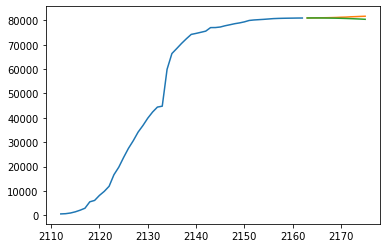

In [98]:
import matplotlib.pyplot as plt

forecast = model.predict(n_periods=len(valid["Confirmed"]))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train["Confirmed"], label='Train')
plt.plot(valid["Confirmed"], label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()


In [61]:
forecast

,Prediction
2163,80952.332833
2164,80962.578810
2165,80962.737929
2166,80952.810193
2167,80932.795599
2168,80902.694149
2169,80862.505842
2170,80812.230679
2171,80751.868659
2172,80681.419782


In [99]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid["Confirmed"],forecast))
print(rms)

604.7418559127435


In [0]:
### Create a function to predict for differernt country:

def ForecastArima(country = "China",forecast_for = 5):
    tms_dat = agg_ldat[agg_ldat.Country == country]
    #Date = pd.date_range(start="2020-01-22",end=data_till)
    #tms_dat["Date"] = Date
    #building the model
    !pip install pyramid.arima
    import numpy as np
    from pyramid.arima import auto_arima
    model = auto_arima(tms_dat['Confirmed'], trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(tms_dat['Confirmed'])
    # Forecasting
    forecast = model.predict(n_periods=forecast_for)
    print(np.around(forecast,0))

In [100]:
# How to use the function: 
# country =  The country for which we looking for forecast.
# forecast_for = number of days for which we try to predict.


ForecastArima(country = "Bangladesh",forecast_for = 5)

  Using cached https://files.pythonhosted.org/packages/5c/84/57422f2a6ade3161c586545e38b518ba1b7ab30ee4a4acc29110c0aba2bc/pyramid_arima-0.9.0-cp36-cp36m-manylinux1_x86_64.whl
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=173.163, BIC=185.926, Fit time=0.149 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=205.750, BIC=210.005, Fit time=0.275 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=196.747, BIC=203.129, Fit time=0.021 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=186.717, BIC=193.099, Fit time=0.036 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=186.656, BIC=197.292, Fit time=0.084 seconds
Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=174.345, BIC=189.235, Fit time=0.397 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=171.165, BIC=181.801, Fit time=0.110 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=187.844, BIC=196.353, Fit time